# Titanic - Machine Learning from Disaster

### Load data

In [128]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
from torch import nn

# Load data from files
test_X = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Split data into X:parameters and y:output
train_y = train["Survived"]
train_X = train.drop(columns="Survived")

### Clean data

In [129]:
# Function for cleaning data

def clean_data(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    
    # Drop unnecessary columns
    to_drop = ["PassengerId","Name","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]
    data.drop(columns=to_drop, inplace=True)

    # Rephrase male and female into discrete values between 0 and 1
    data = data.replace("male", 0)
    data = data.replace("female", 1)

    # Calculate avg age to replace null values with
    avg_age = round(sum(data["Age"].dropna()) / len(data["Age"].dropna()))
    data["Age"] = data["Age"].fillna(avg_age)

    # Calculate max values for normalization of columns
    max_age = max(data["Age"])
    max_pclass = max(data["Pclass"])

    # Normalize values
    data["Pclass"] /= max_pclass
    data["Age"] /= max_age

    return data

# Clean both train and test data
ctrain = clean_data(train_X)
ctest = clean_data(test_X)

# Get labels
train_labels = ctrain.columns

# Put data onto tensors
train_X_tensor = torch.tensor(ctrain.to_numpy())
train_y_tensor = torch.tensor(train_y.to_numpy())
test_X_tensor = torch.tensor(ctest.to_numpy())

data = {}

# Split data into training- and validation sets
train_split = int(0.8 * len(train_X_tensor))
data['X_train'], data['y_train'] = train_X_tensor[:train_split], train_y_tensor[:train_split]
data['X_valid'], data['y_valid'] = train_X_tensor[train_split:], train_y_tensor[train_split:]

### Create model

In [130]:
# Set seed for torch
torch.manual_seed(42)

# Select device (aka cpu/gpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Defining the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.layer_1 = nn.Linear(in_features=3, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = torch.relu(x)
        x = self.layer_2(x)
        x = torch.relu(x)
        x = self.layer_3(x)
        x = torch.sigmoid(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=3, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)


### Train model

In [131]:
# Define accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

def train_model(data, model, hyper_params):
    epochs, lr, momentum = hyper_params
    X_train, y_train = data['X_train'], data['y_train']
    X_valid, y_valid = data['X_valid'], data['y_valid']

    # Set loss function
    loss_fn = nn.BCEWithLogitsLoss()

    # Optimizer
    optim = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)

    y_pred_history = []
    train_acc_history = []
    val_acc_history = []
    loss_history = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        y_pred_train = model(X_train.float()).flatten()
        y_pred_val = None
        with torch.inference_mode():
            y_pred_val = model(X_valid.float()).flatten()
        loss = loss_fn(y_pred_train, y_train.float())

        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Calculate accuracy
        y_pred_train = torch.round(y_pred_train)
        y_pred_val = torch.round(y_pred_val)
        acc_train = accuracy_fn(y_train, y_pred_train)
        acc_val = accuracy_fn(y_valid, y_pred_val)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss: {loss.item()}, Training Accuracy: {acc_train}, Validation Accuracy: {acc_val}")

        loss_history.append(loss.detach())
        train_acc_history.append(acc_train)
        val_acc_history.append(acc_val)

    return loss_history, train_acc_history, val_acc_history

In [132]:
model = NeuralNetwork().to(device)

# Set hyperparameters
epochs = 100
lr = 10
momentum = 0.1
hyper_params = (epochs, lr, momentum)

loss_history, train_acc_history, val_acc_history = train_model(data, model, hyper_params)

Epoch 0: Loss: 0.7707556486129761, Training Accuracy: 78.37078651685393, Validation Accuracy: 79.88826815642457
Epoch 10: Loss: 0.6543253064155579, Training Accuracy: 78.23033707865169, Validation Accuracy: 81.56424581005587
Epoch 20: Loss: 0.6491714715957642, Training Accuracy: 78.37078651685393, Validation Accuracy: 79.88826815642457
Epoch 30: Loss: 0.6476718783378601, Training Accuracy: 78.37078651685393, Validation Accuracy: 79.88826815642457
Epoch 40: Loss: 0.6471917629241943, Training Accuracy: 78.37078651685393, Validation Accuracy: 79.88826815642457
Epoch 50: Loss: 0.6436785459518433, Training Accuracy: 78.37078651685393, Validation Accuracy: 79.88826815642457
Epoch 60: Loss: 0.6321144700050354, Training Accuracy: 77.9494382022472, Validation Accuracy: 81.56424581005587
Epoch 70: Loss: 0.6312870383262634, Training Accuracy: 77.9494382022472, Validation Accuracy: 81.56424581005587
Epoch 80: Loss: 0.631110429763794, Training Accuracy: 77.9494382022472, Validation Accuracy: 81.564

### Visualize training

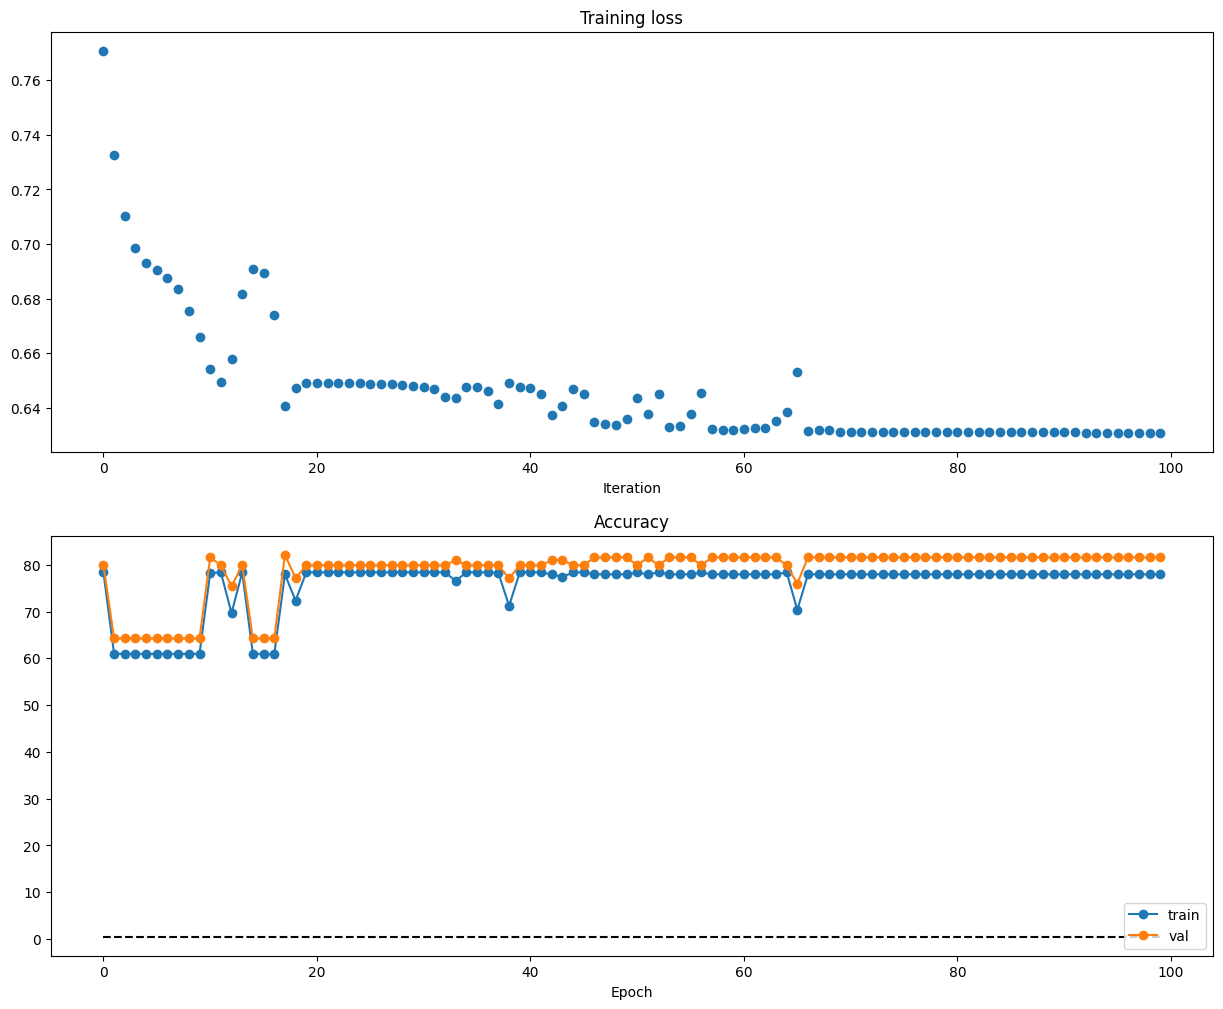

In [133]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_history, '-o', label='train')
plt.plot(val_acc_history, '-o', label='val')
plt.plot([0.5] * len(val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()


### Validate model

In [400]:
with torch.inference_mode():
    y_valid_pred = model(X_valid.float()).flatten()

print(f"Final training: Loss: {loss.item()}, Accuracy: {acc_train}")


loss = loss_fn(y_valid_pred, y_valid.float())
y_valid_pred = torch.round(y_valid_pred)
acc_train = accuracy_fn(y_valid, y_valid_pred)
print(f"Validation: Loss: {loss.item()}, Accuracy: {acc_train}")

Final training: Loss: 0.6376174092292786, Accuracy: 77.9494382022472
Validation: Loss: 0.6380630135536194, Accuracy: 81.56424581005587


### Compute predictions for test data

In [401]:
with torch.inference_mode():
    y_pred_test = model(test_X_tensor.float()).flatten()

y_pred_test = torch.round(y_pred_test)

### Save output to csv

In [402]:
# Revert predictions to NumPy array
y_pred_np = y_pred_test.int().detach().numpy()

# Create a list with the correct indicies
min_i = max(train['PassengerId'])
y_indicies = [min_i+i+1 for i in range(len(y_pred_test))]

# Make a combined list of indicies and predictions
y_data = {'PassengerId': y_indicies, 'Survived': y_pred_np}

# Convert to Pandas Dataframe
y_pred_df = pd.DataFrame(data=y_data)

# Select file name
import os.path

filename = "basicnn_submission.csv"
while os.path.isfile(filename):
    filename = filename[:len(filename)-4] + "(1).csv"

# Send to csv-file
y_pred_df.to_csv(filename,index=False)